##By : Omar Moured

### In this notebook we will learn how to use YOLO .onnx models after exporting them by ultralytics repo [https://github.com/ultralytics]

In [1]:
import onnxruntime # Inference Engine
from PIL import Image 
import numpy as np 
import torch
from utils.general import non_max_suppression
import cv2 # to drow rectangles boxes on the image
import matplotlib.pyplot as plt # to plot the image

In [2]:
# !pip3 install torch==1.6.0

#### Export YOLO from ultralytics

##### Please check the line model.model[-1].export in models/export.py : set it to False. 
##### That is,  model.model[-1].export = False (it means all detection layers output will be concatenated and returned as a single output). 

In [2]:
# RUN in Terminal

#git clone https://github.com/ultralytics/yolov5  # clone repo
#cd yolov5
#pip install -r requirements.txt  # base requirements
#pip3 install onnx>=1.8.0  # for ONNX export
!python3 models/export.py --weights yolov5s.pt --img 640 --batch 2  # export at 640x640 with batch size 1

Namespace(batch_size=2, device='cpu', dynamic=False, half=False, img_size=[640, 640], include=['torchscript', 'onnx', 'coreml'], inplace=False, opset_version=12, optimize=False, simplify=False, train=False, weights='yolov5s.pt')
YOLOv5 \U0001f680 v5.0-102-g7b863a3 torch 1.8.1+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients

PyTorch: starting from yolov5s.pt (14.8 MB)

TorchScript: starting export with torch 1.8.1+cu102...
/jup/tmp/REMOVEME2/yolov5/models/yolo.py:51: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4] or self.onnx_dynamic:
TorchScript: export success, saved as yolov5s.torchscript.pt (29.4 MB)
ONNX: starting export with onnx 1.7.0...
ONNX: export success, saved as yolov5s.onn

#### Initialization

In [3]:
image_path='bus.jpg'
model_path = 'yolov5s.onnx'

# Model configs : can be found in the .yaml file when training
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]
num_classes = 80

# Thresholds for OpenCV Non-Maximum-Supprision (NMS) 
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.5

#### Inference Steps

In [4]:
# Load onnx model
session = onnxruntime.InferenceSession(model_path)

print("The model expects input shape: ", session.get_inputs()[0].shape)
batch_size = session.get_inputs()[0].shape[0]
img_size_h = session.get_inputs()[0].shape[2]
img_size_w = session.get_inputs()[0].shape[3]

The model expects input shape:  [2, 3, 640, 640]


In [25]:
# Load input image (critical step) : The input image should be the same as the expexted input when training.

image_src = Image.open('/jup/tmp/REMOVEME2/yolov5/bus.png').convert('RGB')
print('Loaded Image Info : ',image_src.format, image_src.size, image_src.mode) # size order : width*height

# Resize to img_size_w, img_size_h
resized =  image_src.resize((img_size_w, img_size_h))   # To be imblemnated : letterbox_image(image_src, (img_size_w, img_size_h))
print('After resizing :' ,resized.size, resized.mode) # size order : width*height
#display(resized)

# Preprocess the image
img_in = np.transpose(resized, (2, 0, 1)).astype(np.float32)  # HWC -> CHW
img_in = np.expand_dims(img_in, axis=0) # Add redundant dimension for batch-size (Assumed to be 1, check batch_size = session.get_inputs()[0].shape[0])
img_in /= 255.0 # Normalize all pixels
print('Batch-Size, Channel, Height, Width : ',img_in.shape)

Loaded Image Info :  None (257, 252) RGB
After resizing : (640, 640) RGB
Batch-Size, Channel, Height, Width :  (1, 3, 640, 640)


In [26]:
image_src2 = Image.open('/jup/tmp/REMOVEME2/yolov5/zidane.jpg').convert('RGB')

print('Loaded Image Info : ',image_src2.format, image_src2.size, image_src2.mode) # size order : width*height

# Resize to img_size_w, img_size_h
resized2 =  image_src2.resize((img_size_w, img_size_h))   # To be imblemnated : letterbox_image(image_src, (img_size_w, img_size_h))
print('After resizing :' ,resized2.size, resized2.mode) # size order : width*height
#display(resized)

# Preprocess the image
img_in2 = np.transpose(resized2, (2, 0, 1)).astype(np.float32)  # HWC -> CHW
img_in2 = np.expand_dims(img_in2, axis=0) # Add redundant dimension for batch-size (Assumed to be 1, check batch_size = session.get_inputs()[0].shape[0])
img_in2 /= 255.0 # Normalize all pixels
print('Batch-Size, Channel, Height, Width : ',img_in2.shape)

Loaded Image Info :  None (1280, 720) RGB
After resizing : (640, 640) RGB
Batch-Size, Channel, Height, Width :  (1, 3, 640, 640)


In [27]:
input_batch = np.concatenate([img_in,img_in2], axis=0)

In [28]:
input_batch.shape

(2, 3, 640, 640)

In [29]:
# Feedforward the Image 
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: input_batch})

print('Concatenated outputs shape: ', outputs[0].shape)
print('Separated outputs shape: ', outputs[1].shape, outputs[2].shape, outputs[3].shape)
# 3*80*80 + 3*40*40 + 3*20*20 = 25200
# 85 = 5 (x ,y ,w ,h ,confidence) + 80 (class scores)

Concatenated outputs shape:  (2, 25200, 85)
Separated outputs shape:  (2, 3, 80, 80, 85) (2, 3, 40, 40, 85) (2, 3, 20, 20, 85)


#### Output Parsing

##### Method (1) : PyTorch (Ultralytics NMS function)

In [42]:
filterd_predictions1 = non_max_suppression(torch.tensor(np.expand_dims(outputs[0][1],axis=0)), conf_thres = SCORE_THRESHOLD, iou_thres = NMS_THRESHOLD)
filterd_predictions2 = non_max_suppression(torch.tensor(np.expand_dims(outputs[0][0],axis=0)), conf_thres = SCORE_THRESHOLD, iou_thres = NMS_THRESHOLD)

print(filterd_predictions2) # x1, y1, x2, y2, conf, class_indx

[tensor([[1.19066e+02, 2.28562e+02, 2.38080e+02, 4.90311e+02, 8.66654e-01, 0.00000e+00],
        [2.43900e+02, 2.34026e+02, 3.08217e+02, 4.61849e+02, 7.78898e-01, 0.00000e+00],
        [5.39304e+02, 2.30773e+02, 6.22672e+02, 4.75658e+02, 7.54778e-01, 0.00000e+00],
        [1.69618e+02, 1.45208e+02, 6.09849e+02, 4.09494e+02, 5.60536e-01, 5.00000e+00]])]


In [43]:
# If you didn't change model.model[-1].export to False, uncomment this cell and run it.
# It will automatically reshape the outputs to non_max_suppression function format

# NOT READY 

#### Plot Output

Confidence:  0.5307315 Class: 0


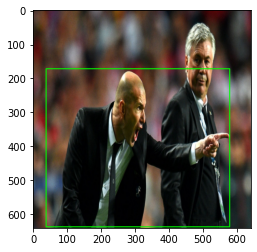

In [44]:
#'/jup/tmp/REMOVEME2/yolov5/bus.png'
#'/jup/tmp/REMOVEME2/yolov5/bus.png'
img = cv2.resize(cv2.imread('/jup/tmp/REMOVEME2/yolov5/zidane.jpg'),(img_size_w,img_size_h)) # Load Image and Resize it to img_size_w*img_size_h
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # BGR TO RGB
for pred in filterd_predictions1[0]:
    pred = pred.detach().cpu().numpy()
    x1 = int(pred[0])
    y1 = int(pred[1])
    x2 = int(pred[2])
    y2 = int(pred[3])
    img = cv2.rectangle(img, (x1,y1),(x2,y2), thickness = 2, color=(0,255,0))
    print('Confidence: ', pred[4], 'Class:', int(pred[5]))
plt.imshow(img)

Confidence:  0.86665386 Class: 0
Confidence:  0.7788976 Class: 0
Confidence:  0.75477815 Class: 0
Confidence:  0.56053615 Class: 5


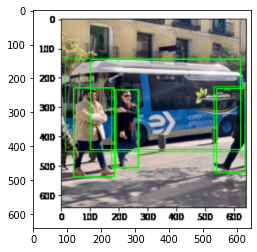

In [45]:
img = cv2.resize(cv2.imread('/jup/tmp/REMOVEME2/yolov5/bus.png'),(img_size_w,img_size_h)) # Load Image and Resize it to img_size_w*img_size_h
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # BGR TO RGB
for pred in filterd_predictions2[0]:
    pred = pred.detach().cpu().numpy()
    x1 = int(pred[0])
    y1 = int(pred[1])
    x2 = int(pred[2])
    y2 = int(pred[3])
    img = cv2.rectangle(img, (x1,y1),(x2,y2), thickness = 2, color=(0,255,0))
    print('Confidence: ', pred[4], 'Class:', int(pred[5]))
plt.imshow(img)

##### Method (2) : Without PyTorch

In [10]:
# NOT READY